In [22]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from tqdm import tqdm
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics
import tenseal as ts

In [16]:
# Importing, balancing, scaling and splitting the dataset into train and test set
df = pd.read_csv(r"C:\Users\manig\Downloads\Mitacs\top_features.csv")

grouped = df.groupby('Label')
df = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))

x = df.drop(["Label"], axis = 1)
y = df["Label"]
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

x = x.reshape(851482, 6, 5)

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.20, random_state=42)
x_val, x_test_20, y_val, y_test_20 = train_test_split(x_temp, y_temp, test_size=0.05, random_state=42)
x_train=torch.from_numpy(x_train).float().unsqueeze(1)
x_val=torch.from_numpy(x_val).float().unsqueeze(1)
x_test_20=torch.from_numpy(x_test_20).float().unsqueeze(1)
y_train=torch.from_numpy(np.array(y_train)).float().unsqueeze(1)
y_val=torch.from_numpy(np.array(y_val)).float().unsqueeze(1)
y_test_20=torch.from_numpy(np.array(y_test_20)).float().unsqueeze(1)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test_20.shape}")
print(f"y_test shape: {y_test_20.shape}")

x_train shape: torch.Size([681185, 1, 6, 5])
y_train shape: torch.Size([681185, 1])
x_val shape: torch.Size([161782, 1, 6, 5])
y_val shape: torch.Size([161782, 1])
x_test shape: torch.Size([8515, 1, 6, 5])
y_test shape: torch.Size([8515, 1])


In [17]:
from collections import Counter
Counter(y_test_20.squeeze().numpy())

Counter({0.0: 4253, 1.0: 4262})

In [4]:
# Since we are training by batch, the swapping time is more than the training time which creates a bottleneck due to which training with cuda will hinder the training time
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device

In [5]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [6]:
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

In [7]:
test_dataset = torch.utils.data.TensorDataset(x_test_20, y_test_20)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [8]:
# for inputs, labels in train_loader:
#     inputs, labels = inputs.to(device), labels.to(device)
# for inputs, labels in test_loader:
#     inputs, labels = inputs.to(device), labels.to(device)

In [3]:
# Model Structure
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()   
        # One convolution  layer becuase TenSEAL restricts this because of the use of im2col operation
        self.conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=0, stride=1)
        self.dense_layer_1 = torch.nn.Linear(in_features=36, out_features=8)
        self.dense_layer_2 = torch.nn.Linear(in_features=8, out_features=1)

    def forward(self, x):
        x = self.conv_layer(x)
        x = x * x
        x = x.view(x.size(0), -1)
        x = self.dense_layer_1(x)
        x = x * x
        x = self.dense_layer_2(x)
        return x

In [14]:
# Function to calculate accuracy, recall, precision and f1 - score
def metrics_fn(y_true, y_pred, others=False):
    for i in range(len(y_pred)):
        if y_pred[i]<0.5:
            y_pred[i] = 0
        else:
            y_pred[i] = 1
            
    accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
    acc = accuracy(y_pred, y_true)
    
    if others==True:
        rec = torchmetrics.Recall(task="binary", num_classes=2)
        prec = torchmetrics.Precision(task="binary", num_classes=2)
        recall = rec(y_pred, y_true)
        precision = prec(y_pred, y_true)
        f1_score = 2*((precision*recall)/(precision+recall))
        del accuracy, rec, prec
        return acc, recall, precision, f1_score
    
    return acc

In [10]:
def train(model, train_loader, val_loader, criterion, optimizer, n_epochs=10):
    
    train_loss_dict = {}
    train_acc_dict = {}
    val_loss_dict = {}
    val_acc_dict = {}
    
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for data, target in train_loader:
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += metrics_fn(target, torch.sigmoid(output))
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        train_loss_dict[epoch] = train_loss
        train_acc_dict[epoch] = train_acc

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            for data, target in val_loader:
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                val_acc += metrics_fn(target, torch.sigmoid(output))
            val_loss = val_loss / len(val_loader)
            val_acc = val_acc / len(val_loader)
            val_loss_dict[epoch] = val_loss
            val_acc_dict[epoch] = val_acc

        if epoch%1 == 0:
            print(f"Epoch {epoch} - Training loss: {train_loss}, Training accuracy: {train_acc}, Validation loss: {val_loss}, Validation accuracy: {val_acc}\n")            
    
    return model, train_loss_dict, train_acc_dict, val_loss_dict, val_acc_dict

In [12]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

Epoch 1 - Training loss: 0.4763588867367591, Training accuracy: 0.8495370745658875, Validation loss: 0.43614640739024985, Validation accuracy: 0.9245129227638245

Epoch 2 - Training loss: 0.20949122535813094, Training accuracy: 0.9310824275016785, Validation loss: 0.6471228319129981, Validation accuracy: 0.9302651882171631

Epoch 3 - Training loss: 0.31166135098372877, Training accuracy: 0.9356136918067932, Validation loss: 0.2562295974510044, Validation accuracy: 0.9322172999382019

Epoch 4 - Training loss: 0.35518304235398157, Training accuracy: 0.9380785822868347, Validation loss: 0.3734334628136197, Validation accuracy: 0.937946081161499

Epoch 5 - Training loss: 0.258332859454393, Training accuracy: 0.9415326118469238, Validation loss: 0.26027674843563475, Validation accuracy: 0.9439062476158142

Epoch 6 - Training loss: 0.16347789343104202, Training accuracy: 0.9438784122467041, Validation loss: 0.17317073752195383, Validation accuracy: 0.9477484226226807

Epoch 7 - Training loss

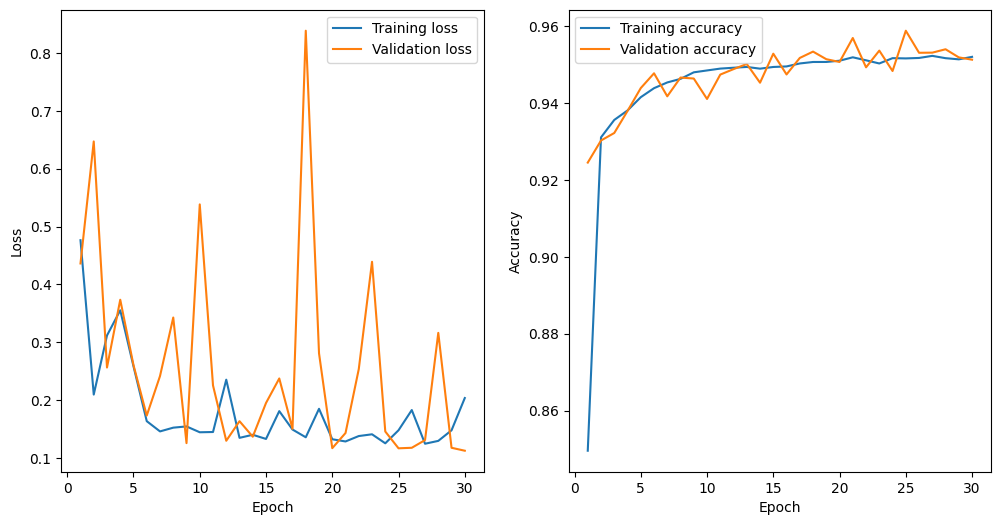

In [33]:
# Training and plotting loss and accuracy curve
torch.manual_seed(42)
model = CNN()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

model, train_loss_dict, train_acc_dict, val_loss_dict, val_acc_dict = train(model, train_loader, val_loader, criterion, optimizer, 30)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(*zip(*train_loss_dict.items()), label='Training loss')
ax1.plot(*zip(*val_loss_dict.items()), label='Validation loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(*zip(*train_acc_dict.items()), label='Training accuracy')
ax2.plot(*zip(*val_acc_dict.items()), label='Validation accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.show()

In [20]:
# Testing on plain data
def test(model, test_loader, criterion):
    test_loss = 0.0
    acc = 0.0
    op = []
    model.eval()
    for data, target in test_loader:
        output = torch.sigmoid(model(data))
        loss = criterion(output, target)
        test_loss += loss.item()
        for i in range(len(output)):
            if output[i]<0.5:
                output[i] = 0
            else:
                output[i] = 1
        opt = output.detach()
        op.extend(opt)
        acc += metrics_fn(y_true=target, y_pred=output)
    loss /= len(test_loader)
    acc /= len(test_loader)
    op = torch.stack(op)
    _, recall, precision, f1 = metrics_fn(y_test_20, op, True)
    
    return {"model_loss": loss.item(),
            "model_acc": acc,
            "recall": recall,
            "precision": precision,
            "f1-score": f1}, op

In [34]:
dict_res, op = test(model, test_loader, criterion)
dict_res

{'model_loss': 0.00044393562711775303,
 'model_acc': tensor(0.9495),
 'recall': tensor(0.9547),
 'precision': tensor(0.9449),
 'f1-score': tensor(0.9498)}

In [4]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "cnn_3_layers.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [37]:
# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH) 

Saving model to: models\cnn_3_layers.pth


In [5]:
model = CNN()
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [6]:
# Extracting weight and bias
class EncCNN:
    def __init__(self, torch_nn):
        self.conv_layer_weight = torch_nn.conv_layer.weight.data.view(torch_nn.conv_layer.out_channels, torch_nn.conv_layer.kernel_size[0],torch_nn.conv_layer.kernel_size[1]).tolist()
        self.conv_layer_bias = torch_nn.conv_layer.bias.data.tolist()
        
        self.dense_layer_1_weight = torch_nn.dense_layer_1.weight.T.data.tolist()
        self.dense_layer_1_bias = torch_nn.dense_layer_1.bias.data.tolist()
        
        self.dense_layer_2_weight = torch_nn.dense_layer_2.weight.T.data.tolist()
        self.dense_layer_2_bias = torch_nn.dense_layer_2.bias.data.tolist()
        
        
    def forward(self, enc_x, windows_nb):
        enc_kernel_bias = []
        
        for kernel, bias in zip(self.conv_layer_weight, self.conv_layer_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_kernel_bias.append(y)
        enc_op = ts.CKKSVector.pack_vectors(enc_kernel_bias)
        enc_op.square_()
        
        enc_op = enc_op.mm(self.dense_layer_1_weight) + self.dense_layer_1_bias
        enc_op.square_()
        
        enc_op = enc_op.mm(self.dense_layer_2_weight) + self.dense_layer_2_bias
        
        return enc_op
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [9]:
def enc_test(context, model, test_loader, criterion, kernel_shape, stride, tqdm_batch):
    tar = []
    op = []
    acc = 0.0
    test_loss = 0.0
    for data, target in tqdm(test_loader):
        x_enc, windows_nb = ts.im2col_encoding(context, data.view(6, 5).tolist(), kernel_shape[0],kernel_shape[1], stride)
        enc_output = enc_model(x_enc, windows_nb)
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)
        loss = criterion(output, target)
        test_loss += loss.item()
        output = torch.sigmoid(output)
        for i in range(len(output)):
            if output[i]<0.5:
                output[i] = 0
            else:
                output[i] = 1
        tar.extend(target)
        opt = output.detach()
        op.extend(opt)
        acc += metrics_fn(y_true=target, y_pred=output)
    test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {test_loss}')
    acc /= len(test_loader)
    print(f"Batch {tqdm_batch} Encrypted Accuracy: {acc}")
#     print(f'Accuracy: {acc}')
    return tar, op

In [8]:
kernel_shape = model.conv_layer.kernel_size
stride = model.conv_layer.stride[0]
print(f"Kernel Shape: {kernel_shape}\nStride: {stride}")

Kernel Shape: (3, 3)
Stride: 1


In [13]:
# poly_mod_degree = 8192
# bits_scale = 26
# integer_scale = 40

# poly_mod_degree = 16384
# bits_scale = 31
# integer_scale = 40

In [10]:
poly_mod_degree = 16384
bits_scale = 31
integer_scale = 40
coeff_mod_bit_sizes = [integer_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, integer_scale]
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_eval.global_scale = 2 ** bits_scale
ctx_eval.generate_galois_keys()

In [18]:
enc_model = EncCNN(model)
y_target_final = []
y_pred_final = []
one_part = y_test_20.shape[0] // 20
for i in range(1, 21):
    if i==1:
        j = one_part
        temp_x_test = x_test_20[:j,]
        temp_y_test = y_test_20[:j,]
    elif i==20:
        j = one_part * (i-1)
        temp_x_test = x_test_20[j:,]
        temp_y_test = y_test_20[j:,]
    else:
        j = one_part * i
        if i == 1:
            k = one_part
        else:
            k = one_part * (i-1)
        temp_x_test = x_test_20[k:j,]
        temp_y_test = y_test_20[k:j,]
    
    test_dataset = torch.utils.data.TensorDataset(temp_x_test, temp_y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
    
    t_start = time.time()
    enc_x_test = []
    print()
    print(f"Starting Batch {i} Encryption & Evaluation")
    target, output = enc_test(ctx_eval, enc_model, test_loader, criterion, kernel_shape, stride, tqdm_batch=i)
    t_end = time.time()
    print(f"Encryption & Evaluation of the test set took {int(t_end - t_start)} seconds")
    y_pred_final.extend(output)
    y_target_final.extend(target)


Starting Batch 1 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:33<00:00,  1.56it/s]


Test Loss: 0.10426690946175937
Batch 1 Encrypted Accuracy: 0.955294132232666
Encryption & Evaluation of the test set took 273 seconds

Starting Batch 2 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:34<00:00,  1.55it/s]


Test Loss: 0.11547653369460753
Batch 2 Encrypted Accuracy: 0.9435294270515442
Encryption & Evaluation of the test set took 274 seconds

Starting Batch 3 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:35<00:00,  1.54it/s]


Test Loss: 1.086863967079167
Batch 3 Encrypted Accuracy: 0.9341176748275757
Encryption & Evaluation of the test set took 275 seconds

Starting Batch 4 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:34<00:00,  1.55it/s]


Test Loss: 0.10559103716787886
Batch 4 Encrypted Accuracy: 0.9576470851898193
Encryption & Evaluation of the test set took 274 seconds

Starting Batch 5 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:35<00:00,  1.54it/s]


Test Loss: 0.09085774338294897
Batch 5 Encrypted Accuracy: 0.9599999785423279
Encryption & Evaluation of the test set took 275 seconds

Starting Batch 6 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:33<00:00,  1.55it/s]


Test Loss: 2.7282116175038884
Batch 6 Encrypted Accuracy: 0.9411764740943909
Encryption & Evaluation of the test set took 273 seconds

Starting Batch 7 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:34<00:00,  1.55it/s]


Test Loss: 1.0646750968408005
Batch 7 Encrypted Accuracy: 0.9435294270515442
Encryption & Evaluation of the test set took 274 seconds

Starting Batch 8 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:33<00:00,  1.56it/s]


Test Loss: 0.13376970942217367
Batch 8 Encrypted Accuracy: 0.9435294270515442
Encryption & Evaluation of the test set took 273 seconds

Starting Batch 9 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:32<00:00,  1.56it/s]


Test Loss: 0.11351538027593469
Batch 9 Encrypted Accuracy: 0.9458823800086975
Encryption & Evaluation of the test set took 272 seconds

Starting Batch 10 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:33<00:00,  1.55it/s]


Test Loss: 0.14083076185359455
Batch 10 Encrypted Accuracy: 0.9576470851898193
Encryption & Evaluation of the test set took 273 seconds

Starting Batch 11 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:33<00:00,  1.56it/s]


Test Loss: 0.10068006955503372
Batch 11 Encrypted Accuracy: 0.9458823800086975
Encryption & Evaluation of the test set took 273 seconds

Starting Batch 12 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:32<00:00,  1.56it/s]


Test Loss: 13.915322008496394
Batch 12 Encrypted Accuracy: 0.9576470851898193
Encryption & Evaluation of the test set took 272 seconds

Starting Batch 13 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:32<00:00,  1.56it/s]


Test Loss: 0.09923651188643867
Batch 13 Encrypted Accuracy: 0.955294132232666
Encryption & Evaluation of the test set took 272 seconds

Starting Batch 14 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:39<00:00,  1.52it/s]


Test Loss: 0.11210817720010656
Batch 14 Encrypted Accuracy: 0.9435294270515442
Encryption & Evaluation of the test set took 279 seconds

Starting Batch 15 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:40<00:00,  1.51it/s]


Test Loss: 1.052958364328553
Batch 15 Encrypted Accuracy: 0.9458823800086975
Encryption & Evaluation of the test set took 280 seconds

Starting Batch 16 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:34<00:00,  1.55it/s]


Test Loss: 1.0384471739975087
Batch 16 Encrypted Accuracy: 0.9599999785423279
Encryption & Evaluation of the test set took 274 seconds

Starting Batch 17 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:33<00:00,  1.56it/s]


Test Loss: 0.11141530430063727
Batch 17 Encrypted Accuracy: 0.955294132232666
Encryption & Evaluation of the test set took 273 seconds

Starting Batch 18 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:32<00:00,  1.56it/s]


Test Loss: 0.17529819628103643
Batch 18 Encrypted Accuracy: 0.9341176748275757
Encryption & Evaluation of the test set took 272 seconds

Starting Batch 19 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [04:35<00:00,  1.54it/s]


Test Loss: 0.2738014512100834
Batch 19 Encrypted Accuracy: 0.9647058844566345
Encryption & Evaluation of the test set took 275 seconds

Starting Batch 20 Encryption & Evaluation


100%|████████████████████████████████████████████████████████████████████████████████| 440/440 [04:43<00:00,  1.55it/s]

Test Loss: 1.7282539058044761
Batch 20 Encrypted Accuracy: 0.9431818127632141
Encryption & Evaluation of the test set took 283 seconds


In [19]:
result = metrics_fn(torch.tensor(y_target_final).float().unsqueeze(1), torch.tensor(y_pred_final).float().unsqueeze(1), True)
print(f"Accuracy: {result[0]}\nRecall: {result[1]}\nPrecision: {result[2]}\nF1-Score: {result[3]}")

Accuracy: 0.9493834376335144
Recall: 0.9570624232292175
Precision: 0.9426854848861694
F1-Score: 0.9498195648193359


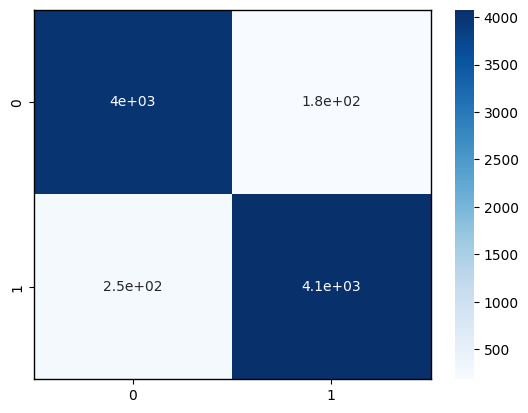

In [20]:
confmat = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)
cnf_matrix_val = confmat(torch.tensor(y_target_final).float().unsqueeze(1), torch.tensor(y_pred_final).float().unsqueeze(1))
cnf_matrix = sns.heatmap(cnf_matrix_val.numpy(), annot=True, cmap='Blues')
for _, spine in cnf_matrix.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
plt.show()

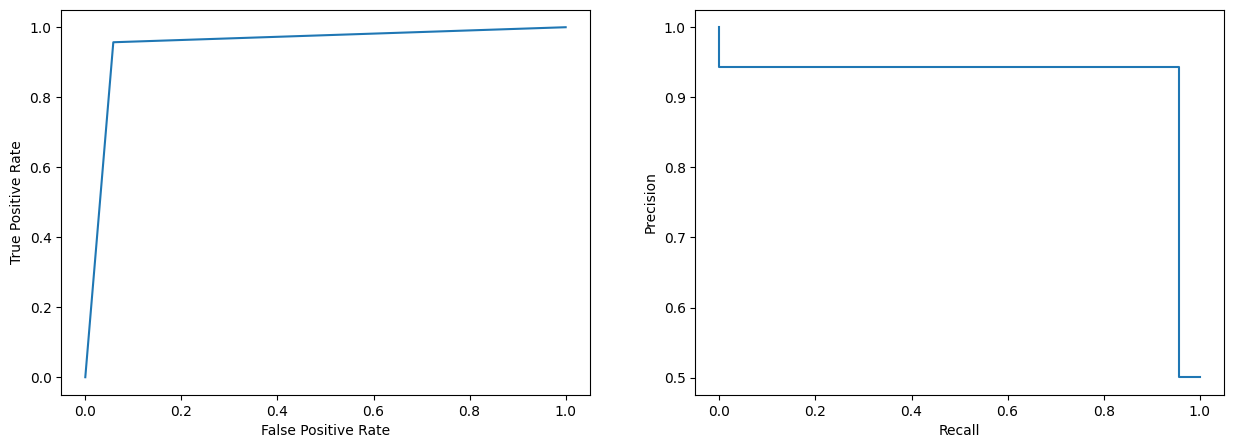

In [23]:
fpr, tpr, _ = roc_curve(torch.tensor(y_target_final).float().unsqueeze(1).numpy(), torch.tensor(y_pred_final).float().unsqueeze(1).numpy())
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
prec, recall, _ = precision_recall_curve(torch.tensor(y_target_final).float().unsqueeze(1).numpy(), torch.tensor(y_pred_final).float().unsqueeze(1).numpy())
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()